# The Elements of Statistical Learning

## Ejercicio completo de machine learning 1: 

Clasificación de puntos en un plano según dos posibles categorias, puntos rojos o azules

Este notebook incluye todos los pasos tipicos de un ejercicio de Machine Learning, enfocandose en un problema de clasificacion entre dos categorias (rojo o azul) de los puntos de un plano. Todo esto en busqueda del grafico 2.4 del libro The Elements. Este notebook se dividirá en las siguientes partes:

- Simulación de datos del train y del test
    - En muchos ejercicios de Machine Learning estos datos son dados como condicion inicial, pero en nuestro caso nosotros los simulamos. Debemos recordar que una de las suposiciones de ML es que los datos siguen cierta funcion de probabilidad y que en principio conociendo esta funcion podriamos simularlos
- Definicion de la función para calcular las predicciones o hacer la clasificacion (lineal, Knn, etc)
    - En el lenguaje de ML esta funcion es llamada Hipótesis
- Definicion de la función costo 
    -  En un primer caso usamos RSS como funcion de costo, pero en general podriamos considerar otras funciones de costo, dependiendo de las propiedades particulares de cada problema
- Minimización de la función costo para encontrar los parámetros libres de la hipótesis 
    - En un primer caso encontramos los valores de los parametros theta de la funcion lineal minimizando analiticamente la funcion costo RSS, en lenguaje de ML esta ecuación es denominada Normal Equation. 
    - Sin embargo es necesario notar que también existen otros metodos, que son numericos en general. Por ejemplo, anteriormente usamos la busqueda aleatoria de los paramteros seleccionando sistematicamente los valores que reducen RSS. Otro metodo, con nombre de hecho, es Gradient Descent que es el mas tipico de Machine Learning.
- Visualizacion de las predicciones en el train y el test
- Evaluacion cuantitativa de las predicciones en terminos de la accuracy y el test error
    - Estos resultados nos permitiran escoger los mejores modelos para el problema planteado
- Gráfico de la misclassification curves (Figure 2.4)

Inicialmente importamos la librería que utilizaremos:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Simulación de datos:

Dado las indicaciones en la pagina 16 del libro "The Elements of Statistical Learning", se puede entender que el proceso de simulación del set de datos de entrenamiento es el siguiente.

1- Primero se escoge el color a simular

2- Dado el color, conocemos el centro y la matriz de covarianza de una gaussiana bivariada

3- Con esta gaussiana bivariada generamos 10 centros. Esto lo hacemos solo una vez porque nos permite generar las observaciones asociadas a un set fijo de gaussianas bivariadas, 10 en nuestro caso. La idea de la simulación es generar observaciones que representen instancias asociados a un set de gaussianas bivariadas, no con respecto a una sola de ellas

4- Con estos valores de los centros, mas una covarianza fija igual a la identidad/5, podemos asumir que conocemos los parametros de 10 gaussianas bivariadas

5- Considerando estas 10 gaussianas bivariadas podemos generar nuestras observaciones

6- Cada observacion se genera de la siguiente forma:

    1- Se escoge uno de los centros dados anteriormente y su gaussiana bivariada correspondiente
    2- Se genera un valor de la posicion siguiendo esta gaussiana bivariada   
    3- Se vuelve a 6.1 y se repite el proceso, 100 veces por cada color

### Definicion de los centros de las gaussianas bivariadas

In [2]:
def centros_asociados_a_cada_color(color, kcentros):
   
    centro = np.array([0,0])
    covarianza = np.identity(2)
    
    if color == 0: #azul
        centro = np.array([1,0])
    
    if color == 1: #rojo
        centro = np.array([0,1])

    lista_de_centros = np.random.multivariate_normal(centro,covarianza,kcentros).T
        
    return lista_de_centros

In [3]:
centros_azul = centros_asociados_a_cada_color(0,10)
centros_rojo = centros_asociados_a_cada_color(1,10)

In [4]:
def visualize_colors(ptos_azul, ptos_rojo):

    x1azul = ptos_azul[0]
    x2azul = ptos_azul[1]
    
    x1rojo = ptos_rojo[0]
    x2rojo = ptos_rojo[1]
    
    plt.plot(x1azul,x2azul,"bo")
    plt.plot(x1rojo,x2rojo,"ro")
    plt.axis([-4,4,-4,4])
    plt.title("Distribucion de puntos segun el color")
    plt.show() 

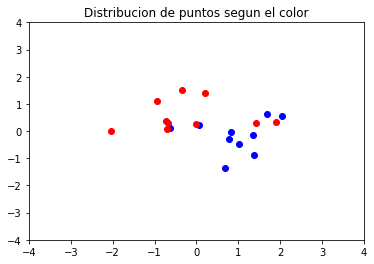

In [5]:
visualize_colors(centros_azul, centros_rojo)

### Implementacion de la funcion que simula los datos

In [6]:
def Simulacion(centros, N):
    
    Ncentros = centros.shape[1]
    
    #Inicializamos la lista de observaciones 
    observations = np.zeros((2,N))
    
    #Definimos un valor global para la covarianza
    covarianza = np.identity(2)/5
       
    #hacemos un loop entre 0 y N para generar todos las observaciones requeridas
    
    for obs in range(0,N):
        #generamos un numero aleatorio entre los números 0 y Ncentros-1 para escoger el centro de nuestra gaussiana bivariada
        indice_del_centro = random.randint(0, Ncentros-1)
        
        xcentro = centros[0,indice_del_centro]
        ycentro = centros[1,indice_del_centro]
        
        mk_centro = np.array([xcentro, ycentro])
        
        centro_aux = np.random.multivariate_normal(mk_centro,covarianza,1).T
    
        observations[0,obs] = centro_aux[0,0]
        observations[1,obs] = centro_aux[1,0]
    
    return observations

### Datos del conjunto de entrenamiento

In [7]:
ptos_observados_azul_train =  Simulacion(centros_azul, 100)
ptos_observados_rojo_train =  Simulacion(centros_rojo, 100)

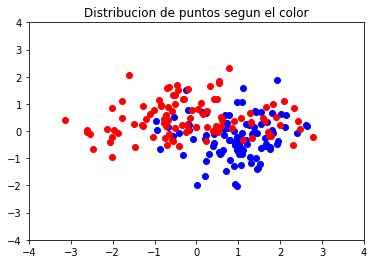

In [8]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

### Datos del  conjunto de testeo
Se generarán 5000 puntos para cada color (en total serán 10000 puntos) a partir de los mismos 20 centros usados para el conjunto de entrenamiento. 

In [9]:
ptos_observados_azul_test =  Simulacion(centros_azul, 5000)
ptos_observados_rojo_test =  Simulacion(centros_rojo, 5000)

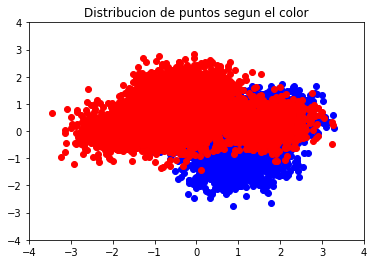

In [10]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

Se generará un segundo conjunto de entrenamiento con 500 puntos para cada color (siendo en total 1000 puntos) a partir de los 20 centros usados para el conjunto de entrenamiento. Esto se realiza debido a las limitaciones de la computadora (en la que se forjó originalmente el código) para analizar el gran número de datos que se formarán más adelante en knn.  

In [11]:
ptos_observados_azul_test_2 =  Simulacion(centros_azul, 500) 
ptos_observados_rojo_test_2 =  Simulacion(centros_rojo, 500)

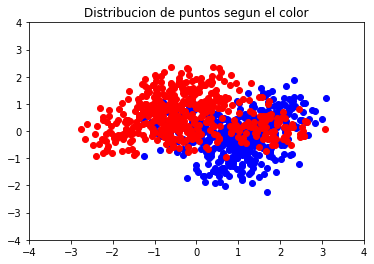

In [12]:
visualize_colors(ptos_observados_azul_test_2, ptos_observados_rojo_test_2)

### Formación del Conjunto de Entrenamiento (SET_train) y del Conjunto de Testeo (SET_test) 

In [13]:
SET_train=[]

x1azul_train = ptos_observados_azul_train[0,:]
x2azul_train = ptos_observados_azul_train[1,:]

x1rojo_train = ptos_observados_rojo_train[0,:]
x2rojo_train = ptos_observados_rojo_train[1,:]

# Se agregan estos puntos a SET_train con su correspondiente valor de Y. Si Y=0 corresponde a 
# la distribución normal azul. Si Y=1 corresponde a la distribución normal roja. Adicionalmente se agregará
# el bias al inicio de cada fila en SET_train.

for i in range(len(x1azul_train)): #Y=0
    SET_train.append([1,x1azul_train[i],x2azul_train[i],0])

for i in range(len(x1rojo_train)): #Y=1
    SET_train.append([1,x1rojo_train[i],x2rojo_train[i],1])

In [14]:
SET_test=[]

x1azul_test = ptos_observados_azul_test[0,:]
x2azul_test = ptos_observados_azul_test[1,:]

x1rojo_test = ptos_observados_rojo_test[0,:]
x2rojo_test = ptos_observados_rojo_test[1,:]

for i in range(len(x1azul_test)): #Y=0
    SET_test.append([1,x1azul_test[i],x2azul_test[i],0])

for i in range(len(x1rojo_test)): #Y=1
    SET_test.append([1,x1rojo_test[i],x2rojo_test[i],1])

Adicionalmente se creará SET_test_2 que corresponde al segundo conjunto de testeo formado para solventar las limitaciones de la computadora en donde se forjó originalemte el código. Si su computadora es capaz de llevar a cabo este tipo de tareas con rapidez utilice SET_test en vez de SET_test_2.

In [15]:
SET_test_2=[]

x1azul_test_2 = ptos_observados_azul_test_2[0,:]
x2azul_test_2 = ptos_observados_azul_test_2[1,:]

x1rojo_test_2 = ptos_observados_rojo_test_2[0,:]
x2rojo_test_2 = ptos_observados_rojo_test_2[1,:]

for i in range(len(x1azul_test_2)): #Y=0
    SET_test_2.append([1,x1azul_test_2[i],x2azul_test_2[i],0])

for i in range(len(x1rojo_test_2)): # Y=1
    SET_test_2.append([1,x1rojo_test_2[i],x2rojo_test_2[i],1])

Los largos correspondientes a cada SET se muestran a continuación.

In [16]:
print(len(SET_train), len(SET_test),len(SET_test_2))

200 10000 1000


## Análisis de funciones para calcular predicciones.

## Caso 1: Función lineal o Mínimos cuadrados

- Hipótesis: función lineal
- Función costo: RSS 
- Minimización: beta obtenido teóricamente (Normal Equation)
- Evaluación: accuracy y test error

En este caso asumimos que el modelo de clasificación o hipotesis esta dado por una funcion lineal del tipo 

$$ f(x1,x2) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 $$

y que los valores de theta son obtenidos a partir de la busqueda del minimo de la funcion RSS con respecto a los datos del conjunto de entrenamiento. Este minimo puede ser encontrado analitcamente, como es nuestro caso actual, pero tambien puede ser encontrado numericamente, por ejemplo utilizando generacion de puntos aleatorios y seleccion del minimo. 

Forma analítica:

$$ RSS(\beta) =  \sum_{i=1}^N (y_i - x_i ^T \beta)^2$$
N indica el número de puntos, los que son de la forma ${(x_1,y_1),(x_2,y_2)...,(x_N,y_N)}$.
Utilizando notación matricial, RSS() queda como:

$$ RSS(\beta) = (Y - X\beta)^T(Y - X\beta)$$

Cabe destacar que en este ejercicio en particular, $\beta$ posee una dimensión igual a 3, Y tiene una dimensión igual a $N$ y X una dimensión de $N x 3$.

Finalmente, para encontrar los coeficientes que componen a vector $\beta$ se debe derivar RSS() con respecto a $\beta$ y luego igualar a 0, con lo que se obtiene lo siguiente.
$$\hat{\beta} = (X^T X)^{-1}X^T Y$$

Otra forma de hacer esta busqueda del minimo de RSS o funcion de costo en el lenguage de Machine Learning es utilizando una tecnica llamada Gradient Descent que es tipica en ML y que aparece explicado en el segundo item del curso Machine Learning de Andrew Ng.

In [17]:
X=[]
Y=[]

#Los valores de SET[i][1] y SET[i][2] se colocarán en X y se vizualizarán como las nuevas variables x1 y x2.
for i in range(len(SET_train)):  
    X.append([1,SET_train[i][1],SET_train[i][2]])


#Ahora se colocarán los valores SET[i][3] en Y.
for i in range(len(SET_train)): 
    Y.append(SET_train[i][3])
    
X=np.array(X)                     
Y=np.array(Y)

XT=X.transpose()

In [18]:
print(X.shape, Y.shape, XT.shape)

(200, 3) (200,) (3, 200)


In [19]:
XTdotX = np.dot(XT,X)
XTdotX

array([[200.        ,  77.8513605 ,  23.17169849],
       [ 77.8513605 , 321.47844061, -20.12005202],
       [ 23.17169849, -20.12005202, 125.2258927 ]])

In [20]:
XTdotX_inversa = np.linalg.inv(XTdotX)
XTdotX_inversa

array([[ 0.00572073, -0.00146637, -0.00129416],
       [-0.00146637,  0.00351809,  0.00083659],
       [-0.00129416,  0.00083659,  0.00835945]])

In [21]:
XTdotX_inversa_dotXT = np.dot(XTdotX_inversa, XT)

In [22]:
beta_analitico = np.dot(XTdotX_inversa_dotXT,Y)
print(beta_analitico)

[ 0.53328852 -0.15897972  0.24681334]


### Visualizacion de las predicciones considerando los datos del conjunto de testeo y del conjunto de entrenamiento

Con el valor del vector beta_analitico es posible visualizar como funciona este modelo de prediccion con la función lineal para los puntos del conjunto de entrenamuiento y del conjunto de testeo separadamente.

Para esto, primero se necesita crear las siguientes funciones:

In [23]:
def funcion_lineal(x1, x2, beta): 
    
    y_prediccion = beta[0] + x1*beta[1] + x2*beta[2]
    return y_prediccion 

In [27]:
def listas_de_predicciones_lineal(SET):

    lista_de_predicciones_azul = []
    lista_de_predicciones_rojo = []

    for pto in range(len(SET)):
        prediccion = funcion_lineal(SET[pto][1], SET[pto][2], beta_analitico)

    #Utilizando el valor de la prediccion separamos entre puntos azules y rojos
    
        if (prediccion <= 0.5):
            lista_de_predicciones_azul.append([SET[pto][1], SET[pto][2]])
        if (prediccion > 0.5):
            lista_de_predicciones_rojo.append([SET[pto][1], SET[pto][2]])
        
    return np.array(lista_de_predicciones_azul), np.array(lista_de_predicciones_rojo)

Ahora para visualizar el modelo tanto para el conjunto de entrenamiento como para el conjunto de testeo haremos lo siguiente.

In [28]:
predicciones_azul_train, predicciones_rojo_train = listas_de_predicciones_lineal(SET_train)

predicciones_azul_train_t = predicciones_azul_train.transpose()
predicciones_rojo_train_t = predicciones_rojo_train.transpose()

In [29]:
predicciones_azul_test, predicciones_rojo_test = listas_de_predicciones_lineal(SET_test)

predicciones_azul_test_t = predicciones_azul_test.transpose()
predicciones_rojo_test_t = predicciones_rojo_test.transpose()

Con esto podemos comparar visualmente las predicciones sobre el conjunto de entrenamiento y el coonjunto de testeo. A continuación se observan los 200 puntos simulados inicialmente que pertenecen al conjunto de entrenamiento.

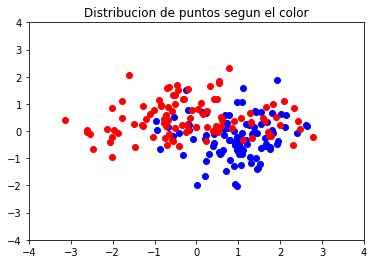

In [30]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

A continuación se observa la predicción hecha por la función lineal en el conjunto de entrenamiento:

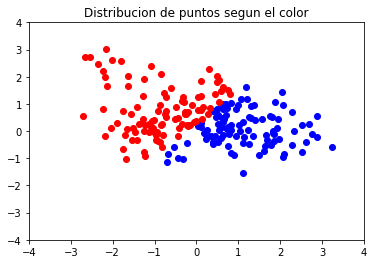

In [41]:
visualize_colors(predicciones_azul_train_t, predicciones_rojo_train_t)

A continuación observamos los 10000 puntos creados anteriormente que pertenecen al SET_test:

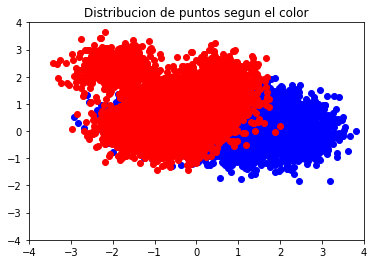

In [42]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

A continuación se observa la predicción hecha por la función lineal para estos puntos pertenecientes a SET_test:

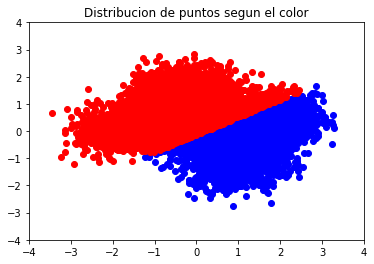

In [31]:
visualize_colors(predicciones_azul_test_t, predicciones_rojo_test_t)

### Evaluación de la hipotesis lineal en terminos de las metricas "Accuracy" y el "Test Error"

Por definicion vamos a considerar que la accuracy y el test error estan dados por

$$Accuracy = \frac{PC}{PC+ PI}$$ 
Con PC los puntos predichos correctamente y PI los puntos predichos incorrectamente

$$Test_{error} = 1 - accuracy$$

Estas son métricas que nos permiten evaluar la performance de la hipótesis (en este caso la función lineal) una vez que hemos encontrado los valores de los parametros libres ($\theta$). Evaluaremos estas dos métricas en ambos conjuntos de datos (el de entrenamiento y el de testeo).

El valor del Accuracy (o la exactitud) medido en el conjunto de entrenamiento nos indica cuantitativamente el nivel de aprendizaje del modelo, dado que en este paso estamos intentando ajustar el modelo a los datos conocidos. Mientras que el Acurracy medido en el conjunto de testeo nos indica su poder de prediccion, dado que estos datos no fueron utilizados para el entrenamiento del modelo. 

Normalmente se espera que el valor de la Accuracy sea mejor (o más cercano a 1) en el conjunto de entrenamiento que en el conjunto de testeo, porque los datos del primer conjunto fueron los utilizados para calcular los parametros del modelo. Sin embargo esto no está garantizado matemáticamente.

En general es recomendable obtener un valor del accuracy cercano a 1 en el conjunto de testeo dado que nuestro objectivo final es tener poder de prediccion, no solo de ajustar los datos conocidos.

In [32]:
def accuracy_funcion_lineal(SET, beta):

    ptos_correctos = 0
    ptos_incorrectos = 0
    
    for pto in range(len(SET)):
        prediccion = funcion_lineal(SET[pto][1], SET[pto][2], beta)
        
        if (((prediccion < 0.5) and (SET[pto][3]==0)) or
            ((prediccion > 0.5) and (SET[pto][3]==1))):
            
            ptos_correctos = ptos_correctos + 1
        else:
            ptos_incorrectos = ptos_incorrectos + 1
            
    ratio = ptos_correctos/(ptos_correctos + ptos_incorrectos)
        
        
    print("puntos correctos: %d y puntos incorrectos: %d"%(ptos_correctos, ptos_incorrectos))
        
    return ratio

### Evaluación del modelo usando el conjunto de entrenamiento

In [33]:
train_accuracy = accuracy_funcion_lineal(SET_train, beta_analitico)
train_error = 1 - train_accuracy
print("train accuracy: %.2f and test error: %.2f "%(train_accuracy, train_error))

puntos correctos: 151 y puntos incorrectos: 49
train accuracy: 0.76 and test error: 0.24 


### Evaluación del modelo usando el conjunto de testeo

In [34]:
test_accuracy = accuracy_funcion_lineal(SET_test, beta_analitico)
test_error = 1 - test_accuracy
print("test accuracy: %.2f and test error: %.2f "%(test_accuracy, test_error))

puntos correctos: 7687 y puntos incorrectos: 2313
test accuracy: 0.77 and test error: 0.23 


## Caso 2: K vecinos más cercanos

- Hipótesis 2: K Nearest Neighbor (kNN)
- Función costo: No existe 
- Minimización: No existe
- Evaluación: Accuracy y Test error

Debemos notar que KNN es un caso bastante particular en Machine Learning dado que no podemos seguir el mismo proceso mencionado anteriormente para la hipótesis lineal, el cual es útil en muchos otros ejemplos. Esto basicamente sucede porque cualquier función de costo que mida la cercanía entre la predicción del color en un punto del conjunto de entrenamiento con los valores conocidos del conjunto entregará N = 1 (un vecino cercano, el mismo punto). 

Por otro lado es posible buscar el valor de N tal que el poder predictivo de KNN sea optimizado. Por ejemplo, se puede buscar aquel valor de N tal que maximize la accuracy con respecto a los datos del test, pero solo usando los puntos del train para el calculo de la prediccion. Esto es lo que nos permite justamente el gráfico 2.4 del libro The Elements.

KNN es un método que busca en las observaciones más cercanas a la que se está tratando de predecir y clasifica el punto de interés basado en la mayoría de datos que le rodean. Para llevar a cabo este algoritmo se deben seguir los siguientes pasos:
- Se debe calcular la distancia entre el punto a clasificar y el resto de puntos del conjunto de entrenamiento.
- Seleccionar los k puntos más cercanos (con menor distancia). Esta sará la tarea de las funciones (creadas más adelante) MinimumDistance() y k_puntos_mas_cercanos()
- Finalmente para clasificar este punto se calculará la clase (valor de Y) que domine dentro de los k puntos más cercanos. Para realizar esta clasificación se obtendrá el promedio de los valores de Y de los k puntos más cercanos y si este promedio es mayor a 0.5 el punto en cuestión pertenecerá a la distribución normal roja y si este promedio es menor o igual a 0.5, el punto será parte de la distribución normal azul. 

--------------------------

Durante la realización de este caso se utilizará el segundo conjunto de testeo SET_test_2 en vez de SET_test, ya que en esta sección del procedimiento mi computadora comienza a tener problemas para procesar los datos. 

In [35]:
def MinimumDistance(punto,SET):
    distancia_min=1000
    for i in range(len(SET)):
        d=np.sqrt((SET[i][1]-punto[0])**2+(SET[i][2]-punto[1])**2)
        if d <= distancia_min:
            distancia_min=d
            punto_min=[SET[i][0],SET[i][1],SET[i][2],SET[i][3]]
    return distancia_min, punto_min  
           

def k_puntos_mas_cercanos(pto,SET,k):
    set_copia =SET.copy()    
    lista_vecinos=[]
   
    for i in range(k):                                  
        punto_cercano = MinimumDistance(pto,set_copia)[1] 
        lista_vecinos.append(punto_cercano)
        set_copia.remove(punto_cercano)
                                                       
    return lista_vecinos  


def promedio(lista_puntos):
    suma_total=0
    prom = 0
    
    if (len(lista_puntos) > 0): #nos aseguramos de que el largo de la lista sea distinto de cero
    
        for elemento in lista_puntos:
            
            suma_total = suma_total + elemento[3]
    
        prom = suma_total / len(lista_puntos)    
    
    return prom


def prediccion_knn(SET,k):
    LISTA_AZUL=[]
    LISTA_ROJO=[]
    
    for elemento in range(len(SET)):
    
        pto = [SET[elemento][1],SET[elemento][2]]
        lista_vecinos_cercanos=k_puntos_mas_cercanos(pto,SET,k)
        y_hat = promedio(lista_vecinos_cercanos)
    
        if y_hat > 0.5:
            LISTA_ROJO.append([SET[elemento][1],SET[elemento][2]])
        else :
            LISTA_AZUL.append([SET[elemento][1],SET[elemento][2]])
    
    return LISTA_AZUL , LISTA_ROJO

Con esto podemos obtener las predicciones según el método KNN. Para visualizar esto, podemos ver como resulta la predicción según 15 vecinos (k=5).

In [36]:
puntosAzul_train, puntosRojo_train = prediccion_knn(SET_train,15)

In [37]:
puntosAzul_test_2, puntosRojo_test_2 = prediccion_knn(SET_test_2,15)

In [39]:
print(len(puntosAzul_train),len(puntosRojo_train),len(puntosAzul_test_2),len(puntosRojo_test_2))

96 104 512 488


In [40]:
puntosAzul_train_t = np.array(puntosAzul_train).transpose()
puntosRojo_train_t = np.array(puntosRojo_train).transpose() 
puntosAzul_test_t = np.array(puntosAzul_test_2).transpose()
puntosRojo_test_t = np.array(puntosRojo_test_2).transpose() 

A continuación observamos los 200 puntos simulados inicialmente pertenecientes al conjunto de entrenamiento:

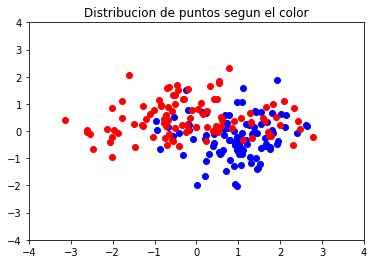

In [41]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

A continuación se observa la predicción hecha por el algoritmo de KNN (K=15) para estos puntos del conjunto de entrenamiento:

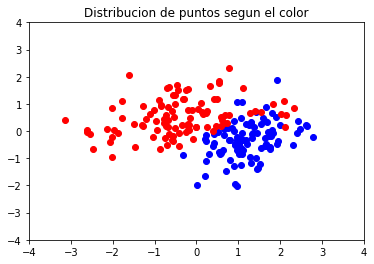

In [42]:
visualize_colors(puntosAzul_train_t,puntosRojo_train_t)

A continuación observamos los 1000 puntos creados anteriormente que pertenecen al SET_test_2:

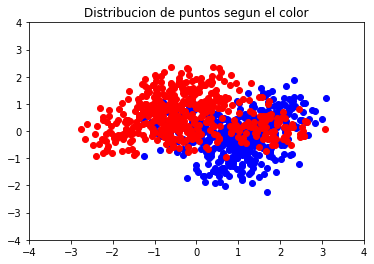

In [43]:
visualize_colors(ptos_observados_azul_test_2, ptos_observados_rojo_test_2)

A continuación se observa la predicción hecha por el algoritmo de KNN (K=15) para estos puntos pertenecientes a SET_test_2:

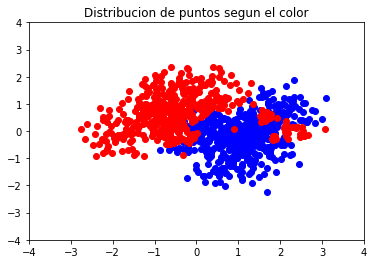

In [44]:
visualize_colors(puntosAzul_test_t,puntosRojo_test_t)

### Evaluación de la hipotesis KNN en terminos de las metricas Accuracy y el Test error

In [45]:
def accuracy_knn(SET, SET_train, k):
    ptos_correctos = 0
    ptos_incorrectos = 0
    
    for pto in range(len(SET)):
    
        punto_de_prueba = [SET[pto][1],SET[pto][2]]
        
        lista_vecinos_cercanos = k_puntos_mas_cercanos(punto_de_prueba,SET_train,k)

        prediccion = promedio(lista_vecinos_cercanos)
                
        if (((prediccion < 0.5) and (SET[pto][3]==0)) or ((prediccion > 0.5) and (SET[pto][3]==1))):

             ptos_correctos = ptos_correctos + 1
                
        else:
            ptos_incorrectos = ptos_incorrectos + 1
            
    ratio = ptos_correctos/(ptos_correctos + ptos_incorrectos)
        
    return ratio

### Evaluación del modelo usando el conjunto de entrenamiento para un k fijo

Primero probaremos la función accuracy_knn(), que fue creada anteriormente, utilizando un numero fijo de vecinos (k=3):

In [46]:
train_accuracy_knn = accuracy_knn(SET_train, SET_train, 3)
train_error_knn = 1 - train_accuracy_knn
print("train accuracy of k=3: %.2f and test error of k=3: %.2f "%(train_accuracy_knn, train_error_knn))

train accuracy of k=3: 0.86 and test error of k=3: 0.14 


### Evaluación del modelo usando el conjunto de testeo 2 para un k fijo

In [47]:
test_accuracy_knn = accuracy_knn(SET_test_2, SET_train, 3)
test_error_knn = 1 - test_accuracy_knn
print("test accuracy of k=3: %.2f and test error of k=3: %.2f "%(test_accuracy_knn, test_error_knn))

test accuracy of k=3: 0.72 and test error of k=3: 0.28 


### Evaluación del modelo usando varios k


Algoritmo:

    - Generamos una lista de valores de k para evaluar el test_error
    - Evaluamos el test_error explorando los puntos del SET_train y evaluando con los puntos del SET_train
    - Evaluamos el test_error explorando los puntos del SET_test_2 y evaluando con los puntos del SET_train
    
Notar que en ambos casos la evaluacion la hacemos usando los puntos del SET_train, dado que en principio no sabemos los colores del SET_test_2 y es justamente lo que estamos buscando predecir, asi que solo podemos usar la informacion del SET_train

In [61]:
k_list = [1]

for i in range(1,30):
    k_list.append(5*i)
    
k_list

[1,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145]

In [62]:
lista_vecinos_train = []           
lista_error_train= []         

print("k, test_error")

for i in k_list:
    test_error = 1 - accuracy_knn(SET_train, SET_train, i)
    print("%d, %.2f"%(i, test_error))  #nos permite ver el avance del programa cuando se ejecuta
    lista_vecinos_train.append(i)
    lista_error_train.append(test_error)

k, test_error
1, 0.00
5, 0.24
10, 0.31
15, 0.23
20, 0.26
25, 0.24
30, 0.26
35, 0.24
40, 0.25
45, 0.24
50, 0.25
55, 0.24
60, 0.24
65, 0.24
70, 0.24
75, 0.24
80, 0.24
85, 0.24
90, 0.24
95, 0.24
100, 0.24
105, 0.23
110, 0.24
115, 0.23
120, 0.25
125, 0.24
130, 0.24
135, 0.23
140, 0.24
145, 0.23


In [63]:
lista_vecinos_test = []
lista_error_test = []

print("k, test_error")

for i in k_list:  #hacemos saltos de a 3 para asimilar lo que sale en el libro
    test_error = 1 - accuracy_knn(SET_test_2, SET_train, i)
    print("%d, %.2f"%(i, test_error))  
    lista_vecinos_test.append(i)
    lista_error_test.append(test_error)

k, test_error
1, 0.31
5, 0.28
10, 0.32
15, 0.26
20, 0.28
25, 0.24
30, 0.26
35, 0.23
40, 0.23
45, 0.22
50, 0.23
55, 0.22
60, 0.23
65, 0.22
70, 0.22
75, 0.22
80, 0.22
85, 0.22
90, 0.22
95, 0.22
100, 0.22
105, 0.21
110, 0.22
115, 0.22
120, 0.22
125, 0.22
130, 0.22
135, 0.22
140, 0.22
145, 0.23


In [64]:
lista_vecinos_train = np.array(lista_vecinos_train)
lista_error_train = np.array(lista_error_train)

lista_vecinos_test = np.array(lista_vecinos_test)
lista_error_test = np.array(lista_error_test)

Con estos datos, podemos visualizar el comportamiento del test_error frente a distintos número de vecinos.

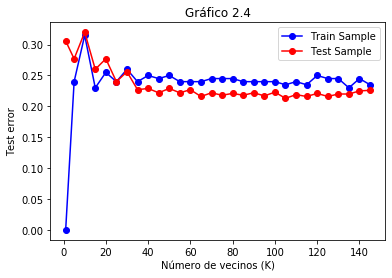

In [65]:
plt.plot(lista_vecinos_train,lista_error_train, "bo-", label = "Train Sample")
plt.plot(lista_vecinos_test,lista_error_test,"ro-", label = "Test Sample")
plt.title("Gráfico 2.4")
plt.xlabel("Número de vecinos (K)")
plt.ylabel("Test error")
plt.legend()
plt.show()

## Conclusiones

- Se simularon los datos siguiendo el procedimiento indicado en el libro "The Elements of Statistical Learning".


- Se construyeron tres conjuntos de datos con distintos tamaños, los cuales fueron visualizados de manera gráfica.


- Se contruiyeron dos modelos de predicción (función lineal y KNN) para clasificar los datos contenindos en los sets de entrenamiento y de testeo. Las predicciones de estos dos modelos fueron visualizadas de manera gráfica. 


- Se construyó el modelo de Función Lineal utilizando la función de costo RSS, que en esta ocasión, fue minimizada de manera analítica (también es posible de manera numérica). Como una próxima tarea se podría utilizar la función de costo gradient descent y comparar que función de consto es más rápida y minimiza de mejor manera el error.


- Se esperaba que el valor del accuracy fuera mejor (más cercano a 1) en el conjunto de entrenamiento que en el de testeo (ya que los datos del conjunto de entrenamiento fueron los utilizados para calcular los parametros del modelo).Sin embargo, esto no se sucedió en el modelo de la función lineal, ya que el accuracy fue mejor en el conjunto de testeo. Esto nos indica que esta hipótesis no siempre se cumple.


- Se analizó el modelo KNN para un K fijo (K=3), del cual se obtubo un mejor accuracy para el conjunto de entrenamiento.


- Se estudió el comportamiento del modelo KNN para varios vecinos, utilizando el set de entrenamiento y el segundo set de testeo (1000 puntos). En la gráfica se observó que a partir de los 30 vecinos el test_error fue mayor para el conjunto de entrenamiento que para el conjunto de testeo. En la gráfica también se observa que a partir de los 40 vecinos (aprox) el valor del test_error es bastante estable para los dos conjuntos de datos. Estos dos hechos no coinciden con lo mostrado en el libro "The Elements of Statistical Learning" (fig 2.4), ya que en esta figura se observa que el error del conjunto de testeo es siempre mayor al del conjunto de entrenamiento, además, en esta figura se observa que a medida que aumenta el número de vecinos, aumenta el error (para los dos conjuntos de datos). ¿Esto podría deberse a que el set de testeo que utilizé (1000 ptos) tiene menos datos que el del libro (10000 ptos)?. 


- El error (test_error) del método KNN es similar al error de la función lineal a partir de los 45 vecinos aprox. 
